## COMP 790.175 Computational Imaging and Displays - Assignment 3: ISP
### EMRE ONEMLI

#### import necessary libraries

In [6]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

### 1.1 Implement a basic image processing pipeline (80 points)

#### **RAW image conversion (5 points)**

dcraw: This is the command name, which invokes the dcraw program.

-4: This flag tells dcraw to output the image in 16-bit linear or "linear gamma" format. By default, dcraw processes images in 8-bit. Using 16-bit allows for more precision, which is beneficial for high-quality post-processing, especially in shadows and highlights.

-d: This option forces dcraw to use the document mode. In document mode, dcraw skips the color interpolation step, resulting in an image where each pixel corresponds directly to a single sensor element. This mode is sometimes referred to as producing a "RAW" image, but in a more direct sense, since no demosaicing is applied. It's useful for archival purposes or when maximum detail is required without interpolation artifacts.

-v: This flag makes dcraw operate in verbose mode, where it outputs detailed information about the processing steps to the console. This can include information about the camera, the image, and the specific processing actions dcraw is taking.

-w: This option tells dcraw to use the camera's white balance settings as specified in the RAW file. Without this flag, dcraw might use its own calculations or defaults for white balance, which could differ from what the camera's software determined.

-T: This flag instructs dcraw to output a TIFF file instead of the default PPM format. TIFF files are widely used in professional photography and graphic design because they support higher bit depths and can include metadata. This is useful for further processing or editing in other software.

In [18]:
# !dcraw -4 -d -v -w -T ../data/baby.nef

In [15]:
'''
Loading Nikon D3 image from ../data/baby.nef ...
Scaling with darkness 0, saturation 16383, and
multipliers 1.628906 1.000000 1.386719 1.000000
Building histograms...
Writing data to ../data/baby.tiff ...
'''
''

''

-4: This flag tells dcraw to output the image in 16-bit linear format. By default, dcraw processes images to an 8-bit depth. Using 16-bit depth increases the image's dynamic range and color depth, allowing for more detailed post-processing, especially in the shadows and highlights where finer gradations are necessary.

-D: The -D flag instructs dcraw to output the RAW image data without any interpolation or processing, producing a grayscale image. This mode is often referred to as "document mode". It essentially bypasses the demosaicing process, where the RAW sensor data is interpolated to produce a full-color image. The result is a direct mapping of the sensor pixels to the image pixels, often used for analytical purposes or as a base for highly customized processing workflows. It’s worth noting that this flag is different from -d (lowercase), which also skips color interpolation but applies some processing.

-T: This flag commands dcraw to save the output file in TIFF format instead of the default PPM (Portable Pixmap) format. TIFF (Tagged Image File Format) is a flexible and widely supported format that can accommodate the high bit depth (16 bits per channel) generated by the -4 flag. It's suitable for archival purposes and is widely used in professional environments for its ability to store image metadata and because it's supported by virtually all image editing software.

In [17]:
# !dcraw -4 -D -T ../data/baby.nef

#### **Python initials (5 points)**

In [7]:
# Path to the TIFF image file
image_path = '../data/baby.tiff'

# Load the image
image = imread(image_path)

# Display the image properties
# TIFF images can be multi-page, but here we assume a single image
if image.ndim == 2:  # Grayscale image
    height, width = image.shape
elif image.ndim == 3:  # Color image
    height, width, _ = image.shape

bits_per_pixel = image.dtype.itemsize * 8  # Multiply byte size by 8 to get bits
print(f'Width: {width}, Height: {height}, Bits per pixel: {bits_per_pixel}')

# Convert the image to a double-precision floating point
image_double = image.astype(np.float64)

# Check the new dtype to confirm conversion
print(f'New dtype: {image_double.dtype}')


Width: 4284, Height: 2844, Bits per pixel: 16
New dtype: float64


#### **Linearization (5 points)**

In [23]:
black = 0  # The black level
white = 16383  # The white level, corresponding to 2^14 - 1

# Linear transformation to normalize the image to [0, 1]
normalized_image = (image_double - black) / (white - black)

# Clipping values outside the [0, 1] range
linear_image = np.clip(normalized_image, 0, 1)


In [24]:
def display_image(image, title=""):
    plt.figure(figsize=(10, 6))
    plt.imshow(image, cmap='gray')  # Use cmap='gray' for grayscale images
    plt.colorbar()  # Optionally add a colorbar to see the intensity scale
    plt.title(title)
    plt.show()

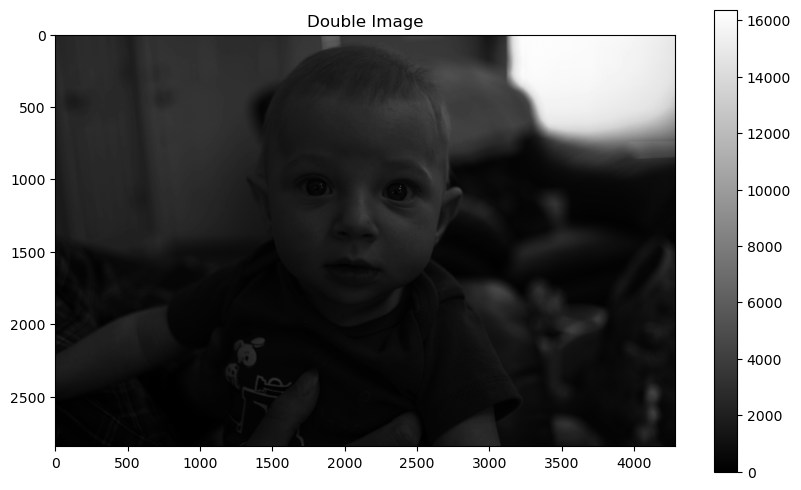

In [31]:
display_image(image_double, "Double Image")

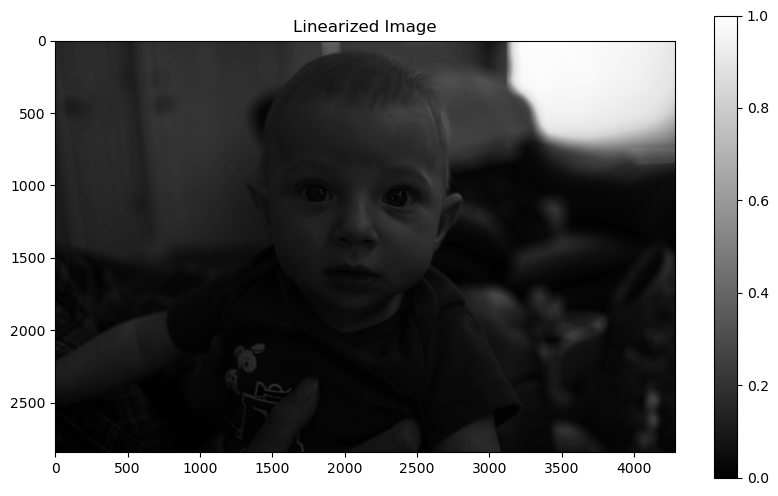

In [32]:
display_image(linear_image, "Linearized Image")

#### **Identifying the correct Bayer pattern (20 points)**

Top-left 2x2 pixels:
 [[0.10712324 0.1833608 ]
 [0.18342184 0.14978942]]


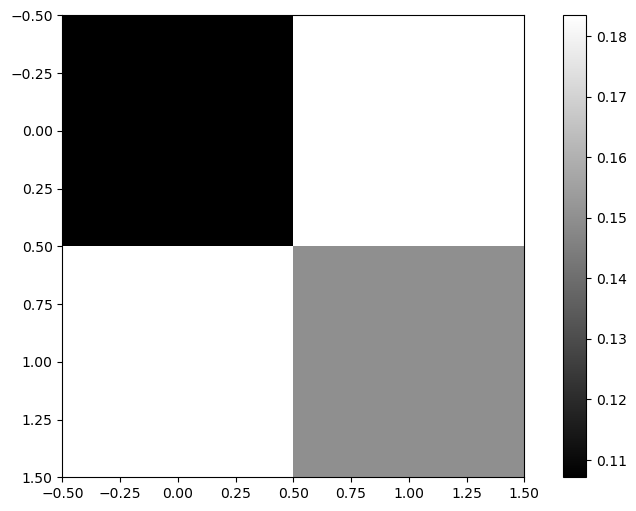

In [30]:
# Display the top-left 2x2 pixels
top_left_2x2 = linear_image[:2, :2]
print("Top-left 2x2 pixels:\n", top_left_2x2)
display_image(top_left_2x2)

Right top and left bottom squares are at the similar brightness, so I think those are green. 

The highest value is 0.18342184, which could indicate a green pixel due to green's higher perceived brightness in most lighting conditions.

The second highest value, 0.1833608, is very close to the highest, suggesting it might be the other green pixel.

The lowest value, 0.10712324, could correspond to the blue pixel, as the blue channel often appears darker due to its shorter wavelength and the typical spectral sensitivity of camera sensors.

The remaining value, 0.14978942, would then be the red pixel, which often captures mid-range intensity values in natural lighting.

The third pattern **"bggr"** is most probable Bayern pattern in the image.

#### **White balancing (10 points)**